In [1]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score, brier_score_loss, f1_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
import shap
from skopt import BayesSearchCV
import skopt.space as space
import skopt.plots as plots
import imblearn
from imblearn.pipeline import Pipeline as imbPipeline
import catboost
from imblearn.over_sampling import SMOTE
from ff_custom_scripts import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score


In [2]:
train, test,leaderboard,holdout = load_files(nanvalues='remove')

alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

meta = pd.read_csv('../metadata/metadata.csv', index_col=0)


(1172, 10396) (294, 10396) (530, 10396) (803, 10396)


In [3]:
meta.head(5)

,varlab,type,one_topic,dtype,gpa,grit,materialHardship,eviction,layoff,jobTraining
new_name,,,,,,,,,,
cf1lenhr,What was the total length of interview - Hours,Continuous,paradata_and_weights,float64,0.000000,0.009892,0.003785,0.000000,0.007810,0.000000
cf1lenmin,What was the total length of interview - Minutes,Continuous,paradata_and_weights,float64,0.000000,0.000000,0.000000,0.001409,0.000000,0.000000
cf1fint,Constructed - Was father interviewed at baseline?,Binary,paradata_and_weights,object,0.021894,0.018859,0.016743,0.028699,0.000000,0.000000
cf1citsm,Constructed - Baseline city sample flag,Binary,paradata_and_weights,object,0.012485,0.023336,0.011364,0.000000,0.016590,0.004293
f1citywt,Father baseline city sample weight (20-cities ...,Continuous,paradata_and_weights,float64,0.000000,0.000000,0.000000,0.009234,0.002574,0.014284


In [4]:
targets = ['gpa','grit','materialHardship','eviction','layoff','jobTraining']

predictors = {target: list(meta[meta[target] != 0].index) for target in targets}

# Model

In [5]:
import lightgbm as lgb

In [6]:
def run_model(train, target='gpa', classifier=False):
    X_train, y_train = prepare_data(train, target)
    
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    ordered_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('target', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ])

    numerical_features = cols_per_type(X_train, 'Continuous')
    categorical_features = cols_per_type(X_train, 'Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    ordinal_features = cols_per_type(X_train, 'Ordinal')
    
    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_features),
        ('passthrough', numerical_features),
        (ordered_transformer, ordinal_features),
        (ordered_transformer, binary_features)
    )
    
    search_space = {
            'regressor__n_estimators': space.Integer(600, 1500),
            'regressor__learning_rate': space.Real(0.01, 0.06),
            'regressor__max_depth': space.Integer(5, 10),
        }
    
    if classifier:
        score = 'neg_brier_score'
        cat_boost = catboost.CatBoostClassifier(verbose=False, loss_function='Logloss', eval_metric='AUC',cat_features=categorical_features)
        search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)})
           
    else:
        cat_boost = catboost.CatBoostRegressor(verbose=False, loss_function='RMSE', eval_metric='RMSE',cat_features=categorical_features)
        score = 'neg_mean_squared_error'
    
        
    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', cat_boost)])
                            
    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=2,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    return model

In [7]:
def score_model(model, target, test, leaderboard, holdout, classifier=False):
    # Get CV score
    score = -model.best_score_
    print(f'Best CV score: {score:.4f}')
    
    # Get mean CV score
    mean_score = -model.cv_results_['mean_test_score'].mean()
    print(f'Mean CV score: {mean_score:.4f}')
    
    # Prepare test data
    X_test, y_test = prepare_data(test, target)

    if classifier:
        # Compute test scores
        y_pred = model.predict(X_test)
        brier = brier_score_loss(y_test, y_pred)
        f1 = f1_score(y_test, y_pred.round())
        
        # Print test scores
        print(f'Test Brier: {brier:.4f}')
        print(f'Test F1: {f1:.4f}')

        # # Compute leaderboard scores
        X_leaderboard, y_leaderboard = prepare_data(leaderboard, target)
        y_pred = model.predict(X_leaderboard)
        brier = brier_score_loss(y_leaderboard, y_pred)
        f1 = f1_score(y_leaderboard, y_pred.round())

        # # Print leaderboard scores
        print(f'Leaderboard Brier: {brier:.4f}')
        print(f'Leaderboard F1: {f1:.4f}')

        # # Compute holdout scores
        X_holdout, y_holdout = prepare_data(holdout, target)
        y_pred = model.predict(X_holdout)
        y_holdout = y_holdout.astype(int)
        brier = brier_score_loss(y_holdout, y_pred)
        print(f'Holdout Brier: {brier:.4f}')
        
        
    else:
        # Compute test scores
        mse = mean_squared_error(y_test, model.predict(X_test))
        rsquared = r2_score(y_test, model.predict(X_test))
        
        # Print test scores
        print(f'Test MSE: {mse:.4f}')
        print(f'Test R2: {rsquared:.4f}')

        # # Compute leaderboard scores
        X_leaderboard, y_leaderboard = prepare_data(leaderboard, target)
        mse = mean_squared_error(y_leaderboard, model.predict(X_leaderboard))
        rsquared = r2_score(y_leaderboard, model.predict(X_leaderboard))

        # Print leaderboard scores
        print(f'Leaderboard MSE: {mse:.4f}')
        print(f'Leaderboard R2: {rsquared:.4f}')

        # # # Compute holdout scores
        # X_holdout, y_holdout = prepare_data(holdout, target)
        # # X_holdout_transformed = model.best_estimator_.named_steps['preprocessor'].transform(X_holdout)
        # mse = mean_squared_error(y_holdout, model.predict(X_holdout))
        # rsquared = r2_score(y_holdout, model.predict(X_holdout))

        # # Print holdout scores
        # print(f'Holdout MSE: {mse:.4f}')
        # print(f'Holdout R2: {rsquared:.4f}')
        
def shap_show(model, alldata, target, n=5):
    X, y = prepare_data(alldata, target)
    model  = model.best_estimator_.fit(X, y)
    Xtransform = model.named_steps['preprocessor'].transform(X)
    exp = shap.TreeExplainer(model.named_steps['regressor'])
    transformer = model.named_steps['preprocessor']
    names = transformer.get_feature_names_out()
    featnames = [splitfeatname(name) for name in names]
    shap_values = exp.shap_values(Xtransform)
    # get top n features
    top_n_idx = np.argsort(np.abs(shap_values).mean(0))[-n:]
    top_n_feat = [featnames[i] for i in top_n_idx]
    # # get questions
    top_n_vars = [meta[meta.index.isin([feat])].varlab.values for feat in top_n_feat]
    # # reverse order
    top_n_vars = top_n_vars[::-1]
    shap.summary_plot(shap_values, Xtransform, max_display=n, feature_names=featnames)
    return dict(zip(map(tuple, top_n_vars), top_n_feat))


# GPA

In [8]:
gpa_model = run_model(train,target='gpa', classifier=False)

In [9]:
gpa_model.best_params_

OrderedDict([('regressor__learning_rate', 0.030505197942665693),
             ('regressor__max_depth', 9),
             ('regressor__n_estimators', 1440)])

In [10]:
score_model(gpa_model,'gpa',test,leaderboard,holdout,classifier=False)

Best CV score: 0.3880
Mean CV score: 0.3898
Test MSE: 0.4375
Test R2: 0.0826
Leaderboard MSE: 0.5627
Leaderboard R2: -0.4406


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


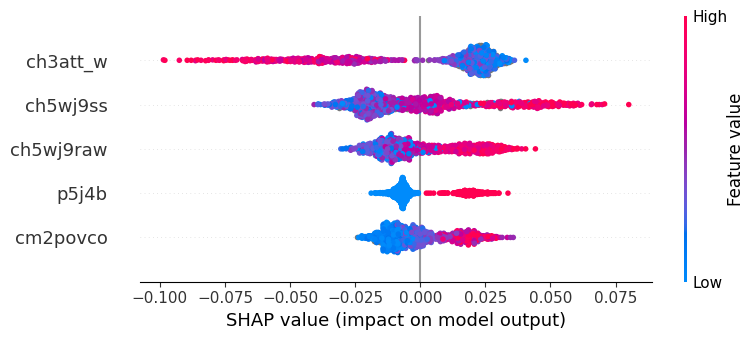

{('attention-seeking',): 'cm2povco',
 ('Woodcock Johnson Test 9 standard score',): 'p5j4b',
 ('Woodcock Johnson Test 9 raw score',): 'ch5wj9raw',
 ('J4B. Child receives free or reduced price lunch',): 'ch5wj9ss',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'ch3att_w'}

In [11]:
shap_show(gpa_model, alldata, target='gpa')

# Material Hardship

In [12]:
model_materialHardship = run_model(train,target='materialHardship', classifier=False)

In [13]:
model_materialHardship.best_params_

OrderedDict([('regressor__learning_rate', 0.030505197942665693),
             ('regressor__max_depth', 9),
             ('regressor__n_estimators', 1440)])

In [16]:
score_model(model_materialHardship, 'materialHardship', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

Best CV score: 0.0194
Mean CV score: 0.0195
Test MSE: 0.0217
Test R2: 0.1443
Leaderboard MSE: 0.0365
Leaderboard R2: -0.2749


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


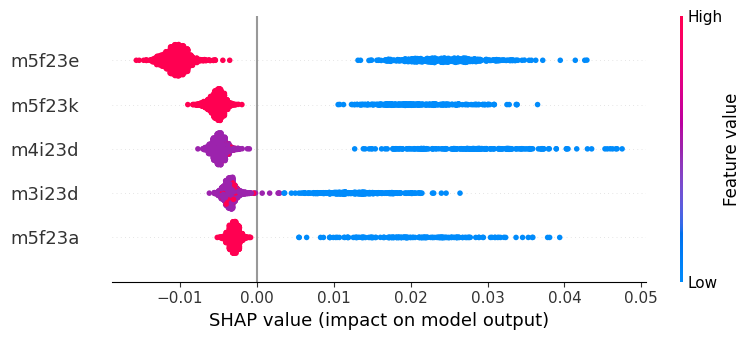

{('F23E. Did not pay full amount of gas/oil/electricity bill in past 12 months',): 'm5f23a',
 ("F23K. Telephone service disconnected because wasn't enough money in past 12 mont",): 'm3i23d',
 ("In past year, did not pay full amt rent/mortgage payments b/c wasn't enough",): 'm4i23d',
 ('In past year, did you not pay full gas/oil/electricity bill?',): 'm5f23k',
 ('F23A. Received free food or meals in past 12 months',): 'm5f23e'}

In [17]:
shap_show(model_materialHardship, alldata, target='materialHardship')


# Grit


In [18]:
model_grit = run_model(train,target='grit', classifier=False)

In [19]:
model_grit.best_params_

OrderedDict([('regressor__learning_rate', 0.05186941777766422),
             ('regressor__max_depth', 9),
             ('regressor__n_estimators', 873)])

In [20]:
score_model(model_grit, target='grit', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

Best CV score: 0.2430
Mean CV score: 0.2436
Test MSE: 0.2370
Test R2: -0.0260
Leaderboard MSE: 0.3079
Leaderboard R2: -0.4012


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


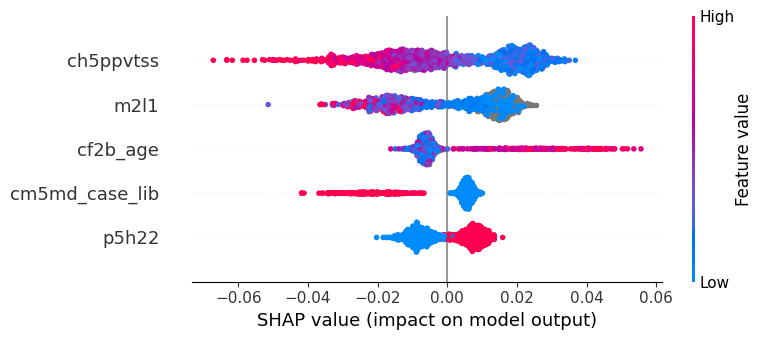

{('PPVT standard score',): 'p5h22',
 ('What was your total household income before taxes last year, all sources?',): 'cm5md_case_lib',
 ("Constructed - Baby's age at time of father's one-year interview (months)",): 'cf2b_age',
 ('Constructed - Mother meets depression criteria (liberal) at nine-year (CIDI)',): 'm2l1',
 ('H22. Child had first menstrual period',): 'ch5ppvtss'}

In [21]:
shap_show(model_grit, alldata, target='grit')

In [22]:
meta[meta.index=='m5a8f01']

,varlab,type,one_topic,dtype,gpa,grit,materialHardship,eviction,layoff,jobTraining
new_name,,,,,,,,,,
m5a8f01,A8F. Your relationship with the father at biol...,Ordered Categorical,romantic_relationships,category,0.0,0.0,0.026602,0.0,0.0,0.0


# Eviction

In [23]:
model_eviction = run_model(train,target='eviction', classifier=True)

In [24]:
score_model(model_eviction, 'eviction', test, leaderboard, holdout, classifier=True)

Best CV score: 0.0549
Mean CV score: 0.0560
Test Brier: 0.0548
Test F1: 0.0000
Leaderboard Brier: 0.0679
Leaderboard F1: 0.0526
Holdout Brier: 0.0834


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


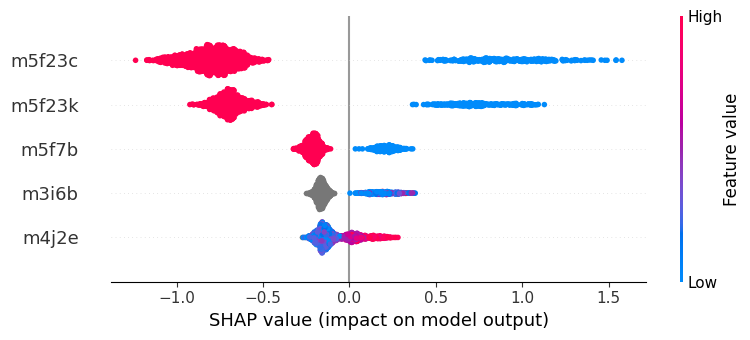

{('F23C. Did not pay full amount of rent/mortgage payments in past 12 months',): 'm4j2e',
 ("F23K. Telephone service disconnected because wasn't enough money in past 12 mont",): 'm3i6b',
 ('F7B. Received help from a welfare office or welfare job placement in past 12 mon',): 'm5f7b',
 ('How many days in past year did you go without phone service?',): 'm5f23k',
 ('How much do you weigh?',): 'm5f23c'}

In [25]:
shap_show(model_eviction, alldata, target='eviction')

# jobTraining

In [26]:
model_job = run_model(train,target='jobTraining', classifier=True)

In [28]:
score_model(model_job,'jobTraining',test,leaderboard,holdout,classifier=True)

Best CV score: 0.1923
Mean CV score: 0.2034
Test Brier: 0.2158
Test F1: 0.1600
Leaderboard Brier: 0.3321
Leaderboard F1: 0.0737
Holdout Brier: 0.3313


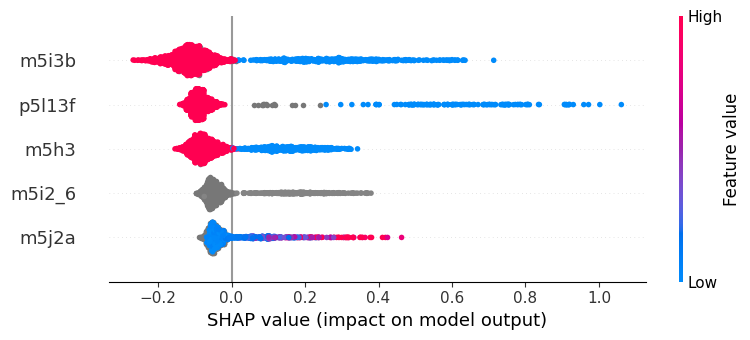

{('I3B. You have taken classes to improve job skills since last interview',): 'm5j2a',
 ('L13F. Gifted and talented program',): 'm5i2_6',
 ('H3. You had a religious experience that transformed your life since last intervi',): 'm5h3',
 ('I2_6. Attending program to improve reading',): 'p5l13f',
 ('J2A. Amount you gave/loaned money to friends/relatives during past 12 months',): 'm5i3b'}

In [ ]:
shap_show(model_job, alldata, target='jobTraining')

# Layoff

In [ ]:
model_layoff = run_model(train, target='layoff', classifier=True)

In [ ]:
model_layoff.best_params_

OrderedDict([('regressor__gamma', 0.2218593982536045),
             ('regressor__learning_rate', 0.018593578069828035),
             ('regressor__max_depth', 8),
             ('regressor__min_child_weight', 5),
             ('regressor__n_estimators', 1071),
             ('regressor__scale_pos_weight', 3)])

In [ ]:
score_model(model_layoff, 'layoff', test, leaderboard, holdout, classifier=True)

Best CV score: 0.1760
Mean CV score: 0.1900
Test Brier: 0.2054
Test F1: 0.0000
Leaderboard Brier: 0.2472
Leaderboard F1: 0.1208
Holdout Brier: 0.2428


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


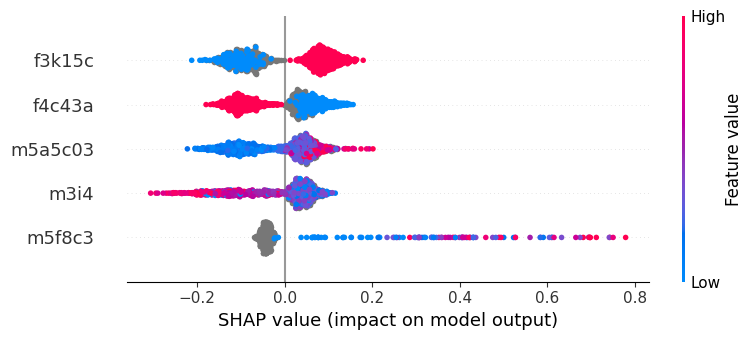

{('In addition sometimes work: nights?',): 'm5f8c3',
 ("Since child's birth, has there been time when mother  felt sad/depressed?",): 'm3i4',
 ('A5C. Age of household member',): 'm5a5c03',
 ('How much rent do you pay each month?',): 'f4c43a',
 ('F8C3. Approximate amount received in the last month you received other assistanc',): 'f3k15c'}

In [ ]:
shap_show(model_layoff, alldata, target='layoff')